Camera Calibration with OpenCV
===

### Run the code in the cell below to extract object points and image points for camera calibration.  

In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

### If the above cell ran sucessfully, you should now have `objpoints` and `imgpoints` needed for camera calibration.  Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image

In [ ]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

print (dist)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('reportPict/undist_calibration1.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

Pipeline (test images)
===

### Run the code in the cell below to undistort source images

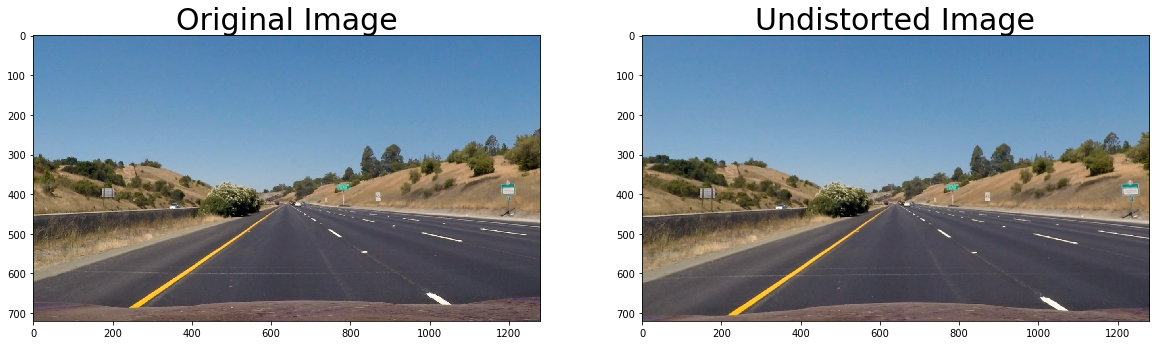

In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
%matplotlib qt
%matplotlib inline

dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) ) # read distortion coeficinets calculated above
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
images = glob.glob('test_images/*.jpg')
undist = []
for imgName in images:
    img = cv2.imread(imgName)
    undistImg = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('reportPict/'+imgName ,undistImg)
    undist.append(undistImg)

# Visualize example
img = cv2.imread(images[0])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(undist[0], cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)

### Run the code in the cell below to convert images to binary format

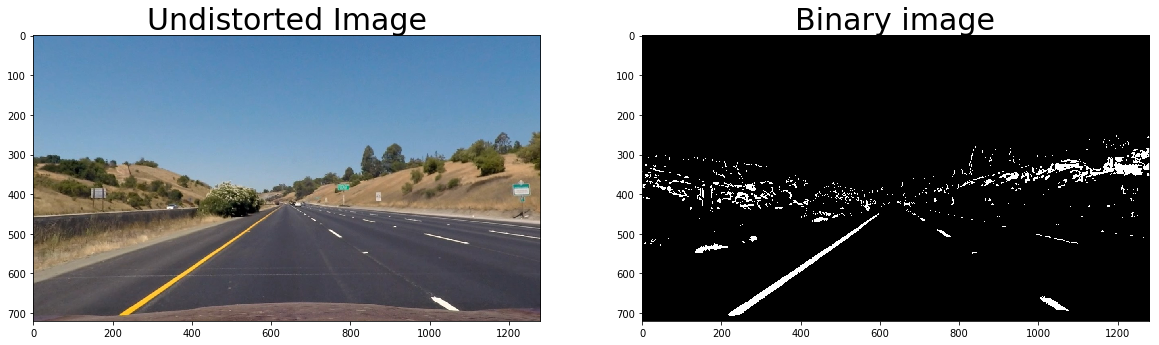

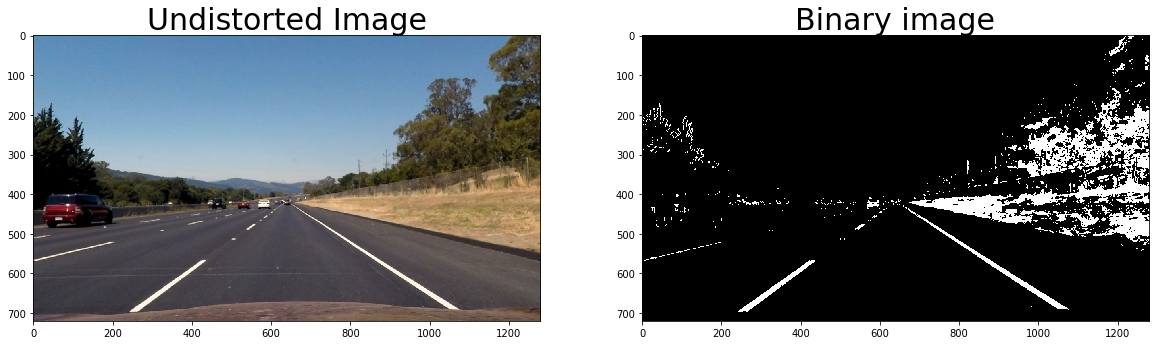

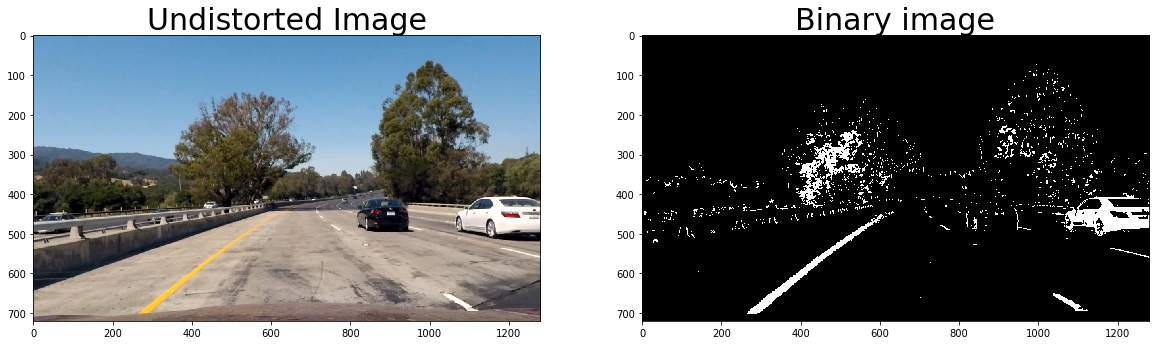

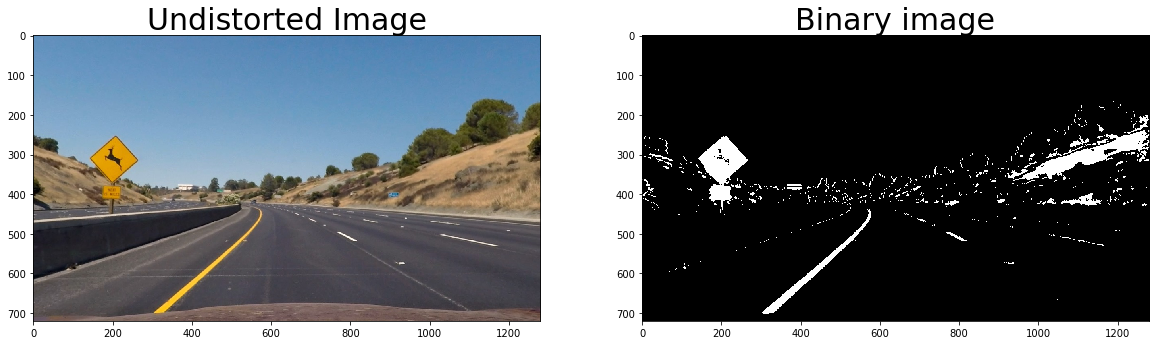

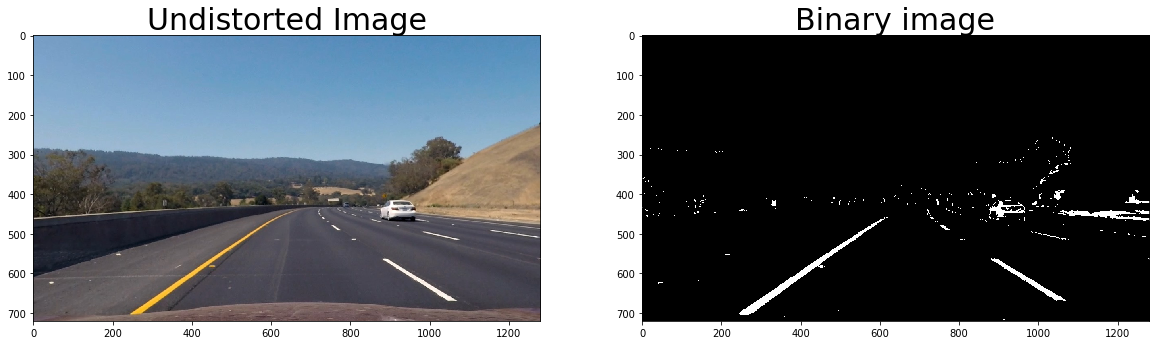

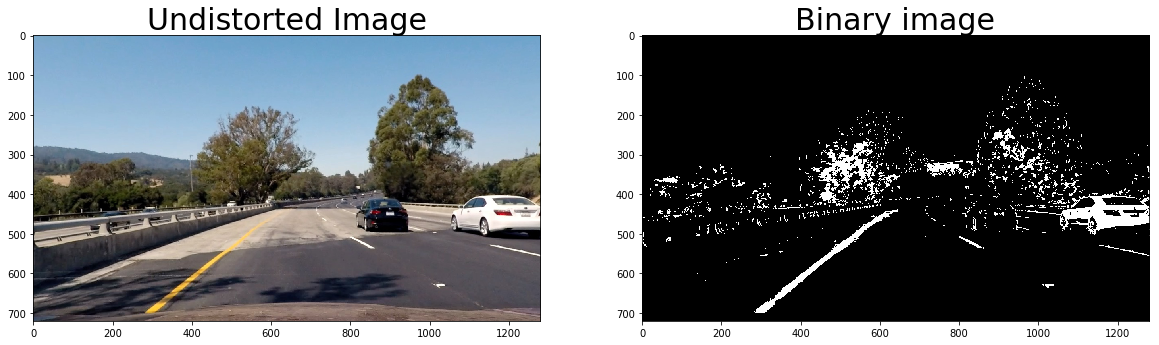

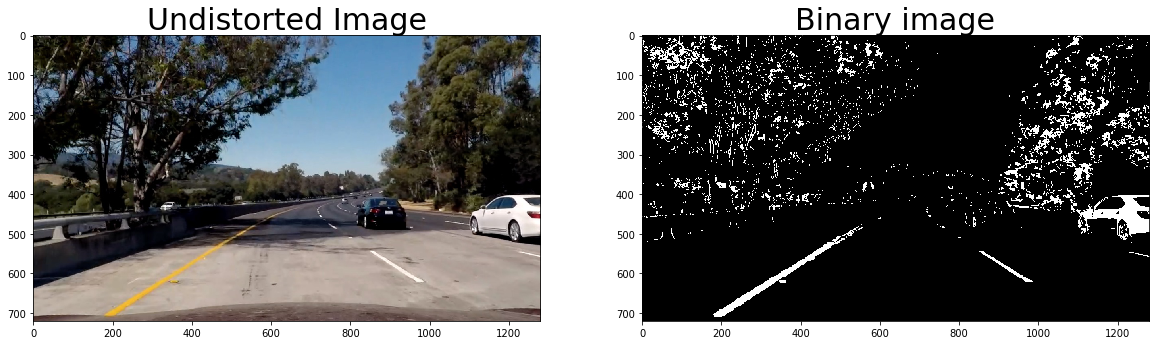

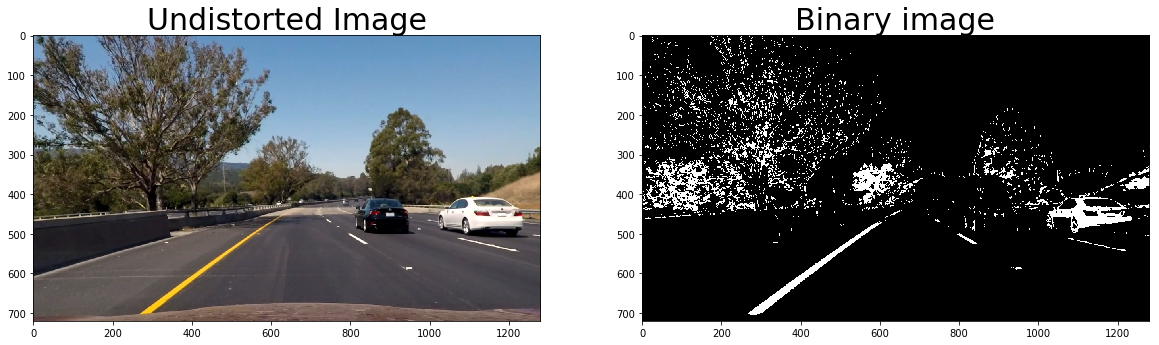

In [2]:
# s_thres filters s channels sx thres is x derivative in s and l and l thresh is defining which pixels should be ignored because too dark in s channel
'''
def convertToBin(img, s_thresh=(90, 255), sx_thresh=(30, 255), l_thresh=(30,255)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel+s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # threshold dark pixels
    # Stack each channel
    l_binary = np.zeros_like(s_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    resultBin = np.zeros_like(sxbinary)
    resultBin[(sxbinary == 1) | ((s_binary == 1) & (l_binary == 1))] = 1
    return resultBin
'''
def convertToBin(img, yellowH=(15, 25), yellowS=(90, 255), whiteL=(215,255), lxThresh=(60, 255)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    hChannel = hls[:,:,0]
    lChannel = hls[:,:,1]
    sChannel = hls[:,:,2]
    
    # Sobel x aver s and l channels
    sobelx = cv2.Sobel(lChannel, cv2.CV_64F, 1, 0) # Take the derivative in x
    absSobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaledSobel = np.uint8(255*absSobelx/np.max(absSobelx))
    # Threshold x gradient
    lxBinary = np.zeros_like(scaledSobel)
    lxBinary[(scaledSobel >= lxThresh[0]) & (scaledSobel <= lxThresh[1])] = 1    
    
    # Threshold yellow pixels
    yellowBinary = np.zeros_like(hChannel)
    yellowBinary[(hChannel >= yellowH[0]) & (hChannel <= yellowH[1]) & (sChannel >= yellowS[0]) & (sChannel <= yellowS[1])] = 1
    
    # threshold white pixels
    whiteBinary = np.zeros_like(lChannel)
    whiteBinary[(lChannel >= whiteL[0]) & (lChannel <= whiteL[1])] = 1
    # Stack each channel 
    resultBin = np.zeros_like(whiteBinary)
    resultBin[(yellowBinary == 1) | (whiteBinary == 1) | (lxBinary == 1)] = 1
    return resultBin
binaryList = []
for undistImg in undist:
    binaryList.append(convertToBin(undistImg,))

# Visualize all undistorted images and binary versions too
for undistImg, binImg in zip(undist, binaryList):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(cv2.cvtColor(undistImg, cv2.COLOR_BGR2RGB))
    ax1.set_title('Undistorted Image', fontsize=30)
    ax2.imshow(binImg, cmap='gray')
    ax2.set_title('Binary image', fontsize=30)

### Run the code in the cell below to transform binary format to bird eye view

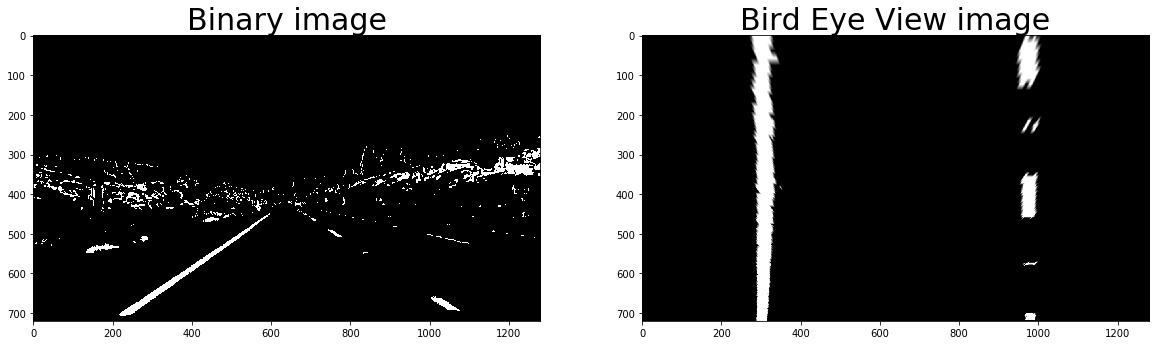

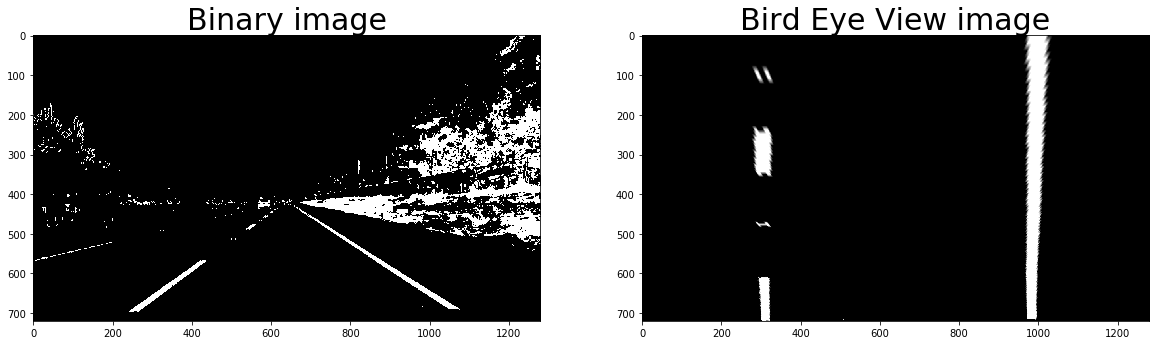

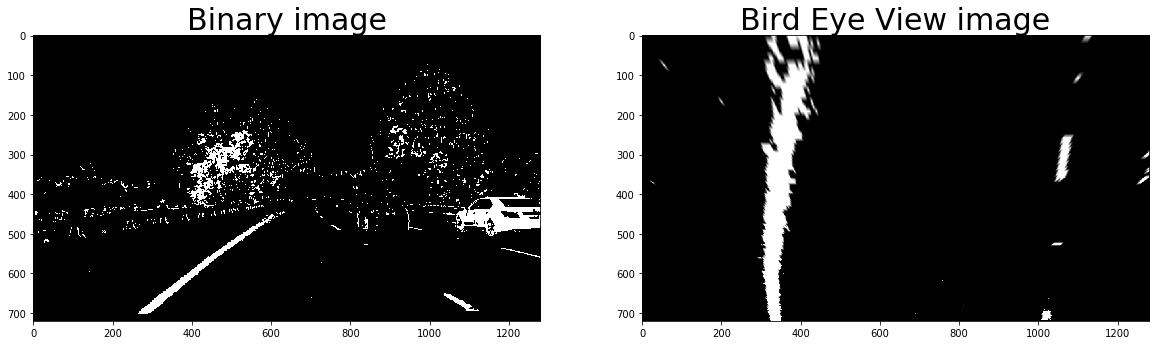

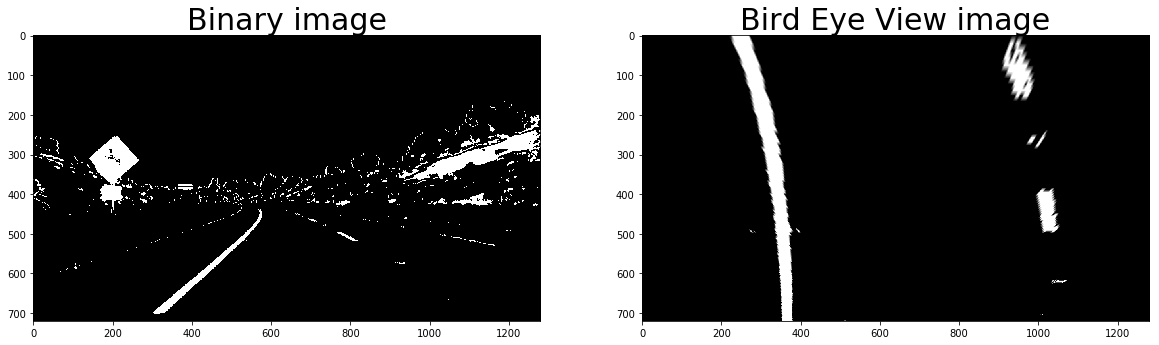

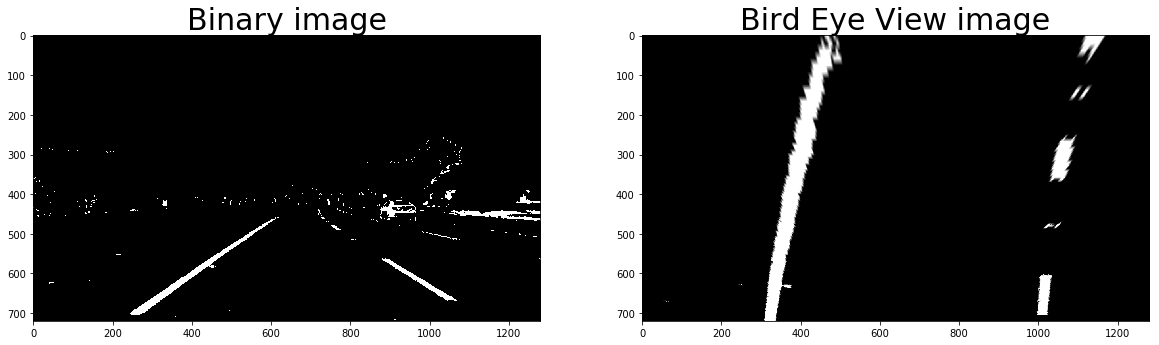

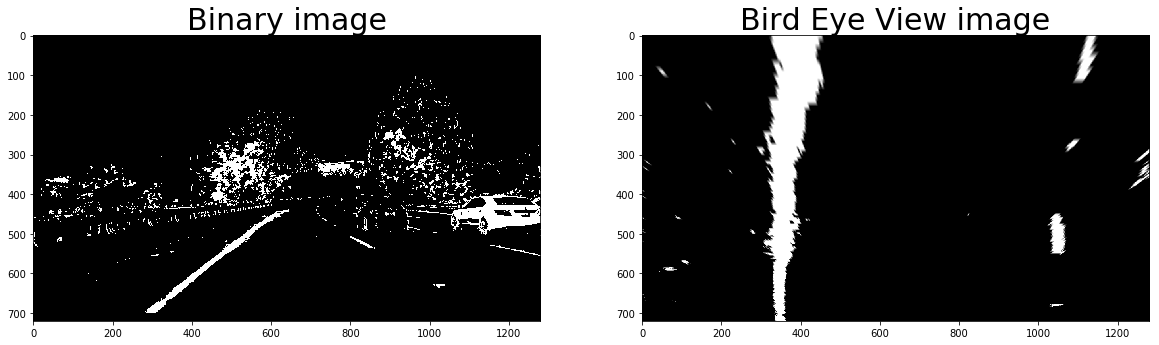

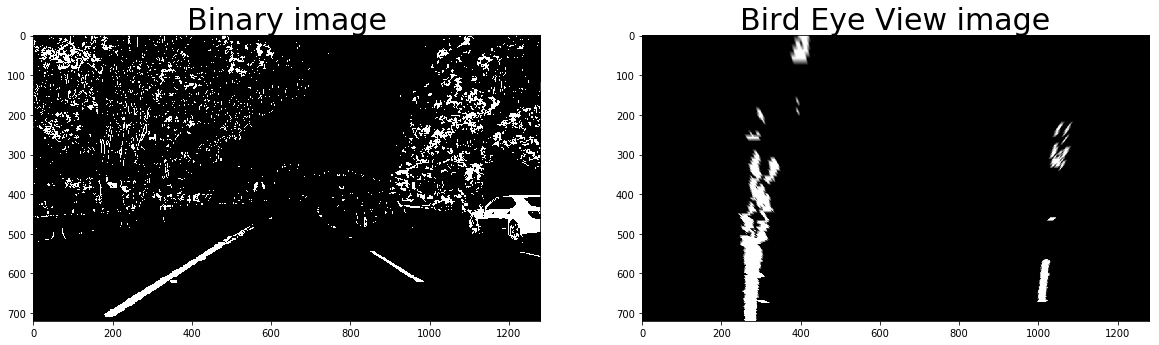

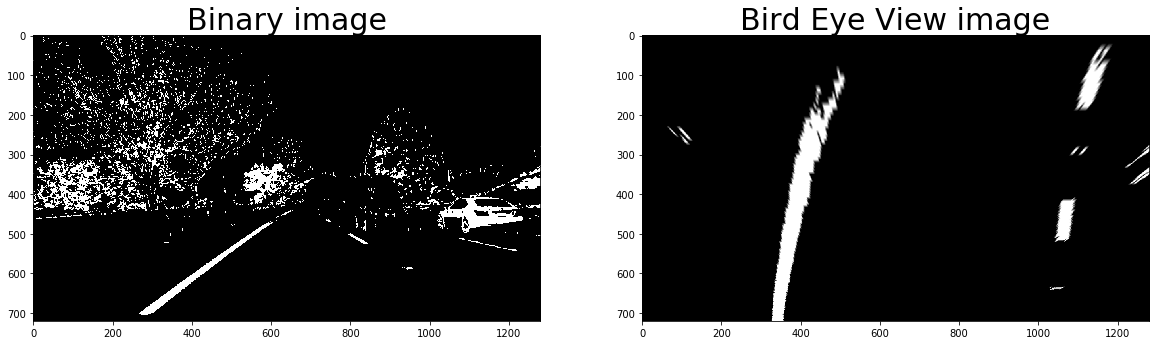

In [3]:
img_size = (binaryList[0].shape[1], binaryList[0].shape[0])
offset = 300
src = np.float32([[580,460], [702,460], [233,700], [1075,700]])
#src = np.float32([[583,460], [702,460], [233,700], [1075,700]])
dst = np.float32([[offset, 0], [img_size[0]-offset, 0], 
                 [offset, img_size[1]], 
                 [img_size[0]-offset, img_size[1]]])
birdEyeList = []
for binaryImg in binaryList:
    M = cv2.getPerspectiveTransform(src, dst)
    birdEyeList.append(cv2.warpPerspective(binaryImg, M, img_size , flags=cv2.INTER_LINEAR))
i=0
# Visualize all binary images and birdeye versions
for binImg, birdEyeImg in zip(binaryList, birdEyeList):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(binImg, cmap='gray')
    ax1.set_title('Binary image', fontsize=30)
    ax2.imshow(birdEyeImg, cmap='gray')
    ax2.set_title('Bird Eye View image', fontsize=30)
    #i= i+1
    #cv2.imwrite('reportPict/'+str(i)+'.jpg' ,birdEyeImg*255)

### Run the code in the cell below to detect lines

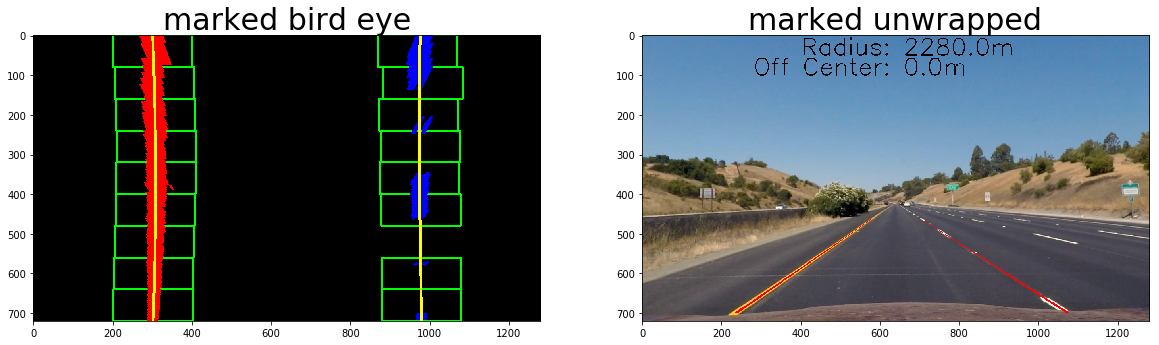

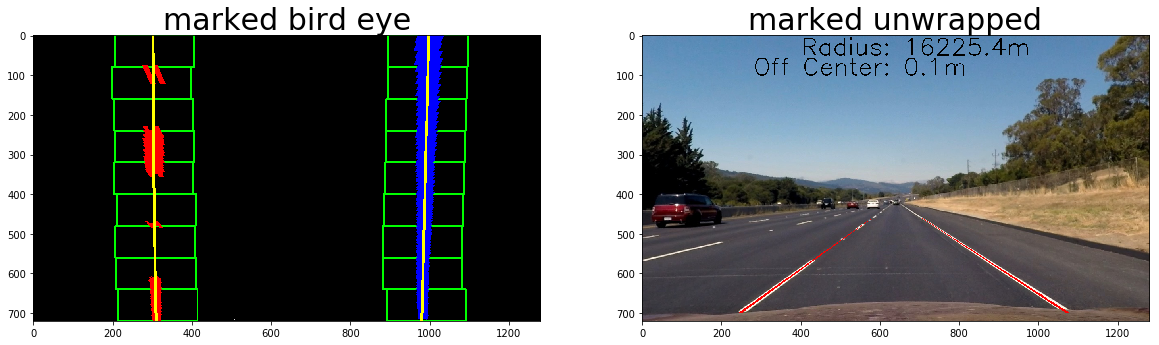

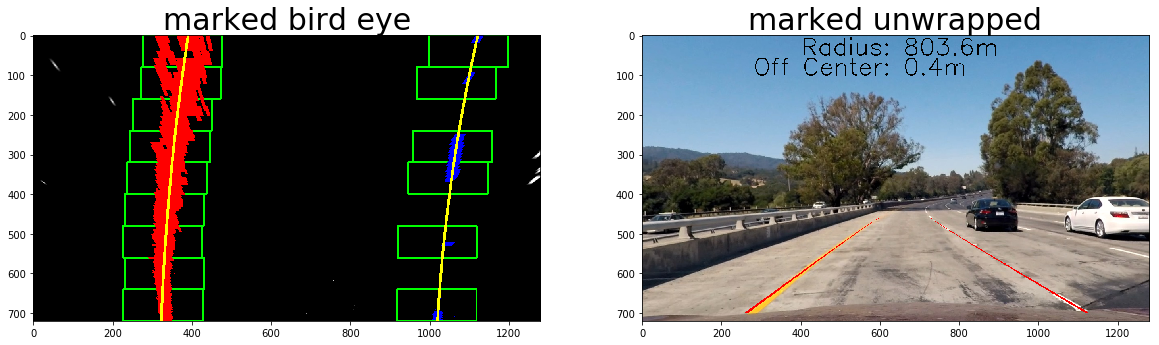

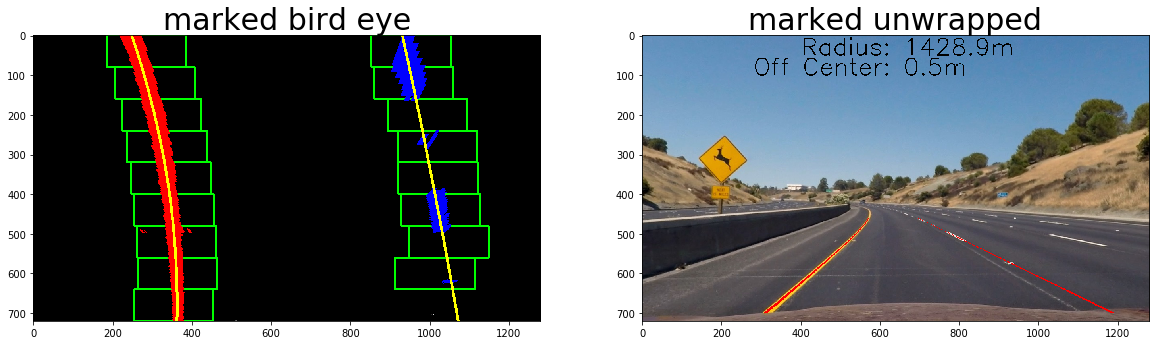

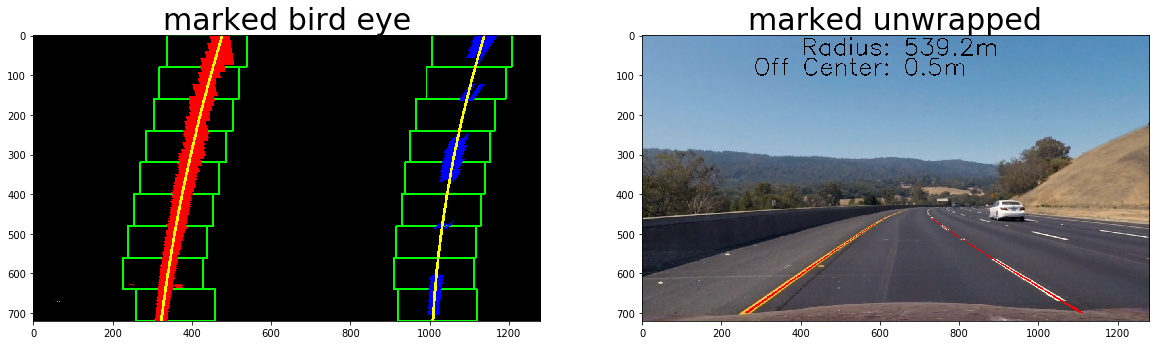

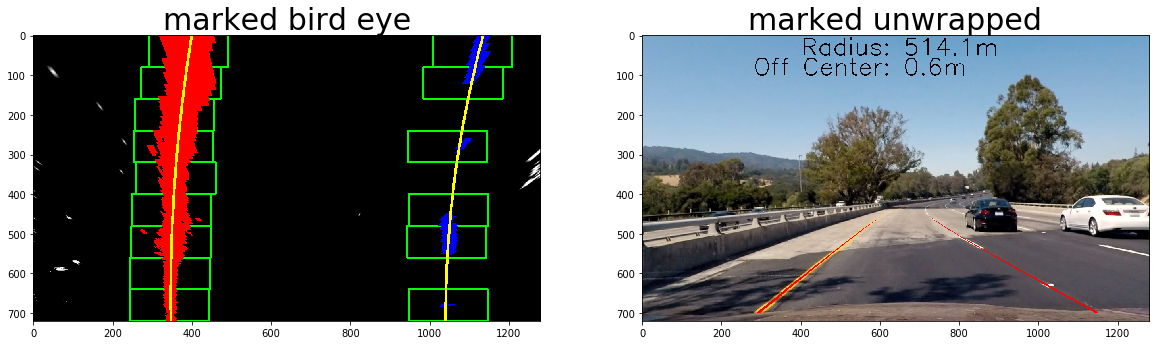

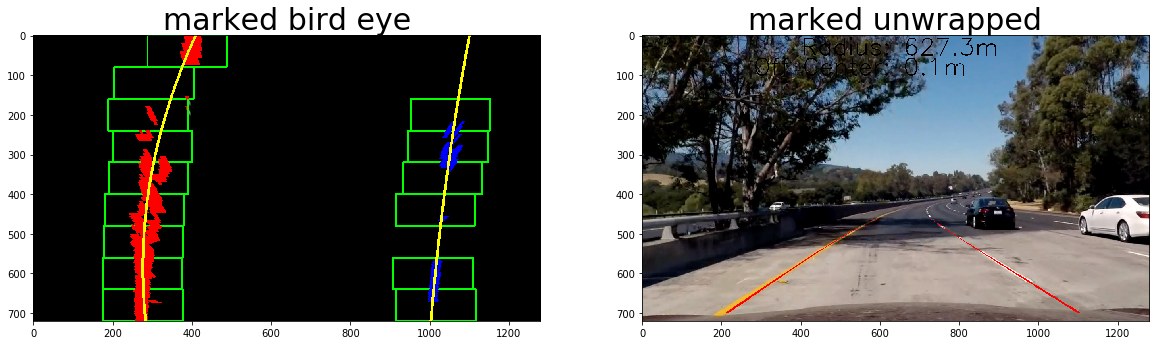

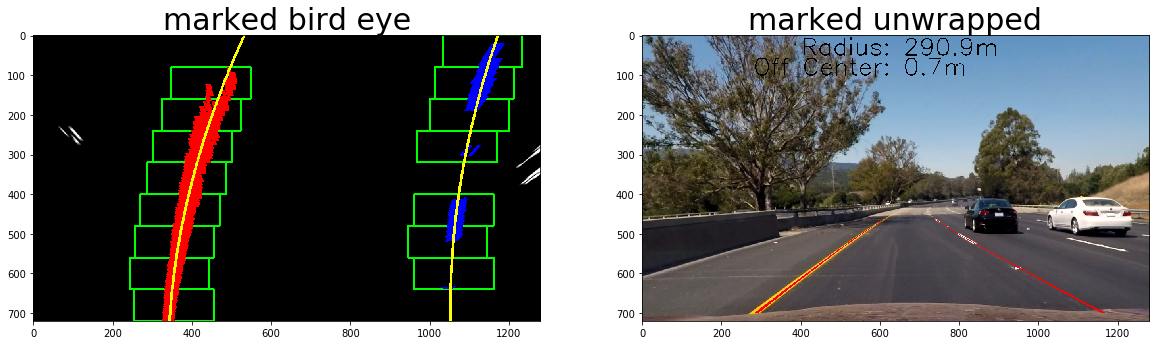

In [4]:
# Conversions in x and y from pixels space to meters
ymPerPix = 3.0/(358.0-462.0) # based on dashed line measured on bird eye view and real life line legth of 3m
xmPerPix = 3.7/(978.0-302.0) # based on line width measured on bird eye view and real life line width of 3.7m
# polyCoef - Coeficients of polymial of left line in pixel space
# yEval - where radius should be calculated in y pixels
def calculateRadius(polyCoef, yEval):
    #x= mx / (my ** 2) *a*(y**2)+(mx/my)*b*y+c
    polyCoefMeters = np.array([polyCoef[0]*(xmPerPix/(ymPerPix**2)), polyCoef[1]*(xmPerPix/ymPerPix), polyCoef[2]])
    #polyCoefMeters = np.array([polyCoef[0], polyCoef[1]*(xmPerPix/ymPerPix), polyCoef[2]*(xmPerPix/(ymPerPix**2))])
    # Calculate the radius of curvature
    radius = ((1 + (2*polyCoefMeters[0]*yEval*ymPerPix + polyCoefMeters[1])**2)**1.5) / np.absolute(2*polyCoefMeters[0])
    #radius = ((1 + (2*polyCoef[0]*yEval + polyCoef[1])**2)**1.5) / np.absolute(2*polyCoef[0])
    return radius
                         
    
# img - input bird eye view binary image
# undistImg - undistorted BGR image
# margin - The width of the windows +/- margin
# minpix- minimum number of pixels found to recenter window
def markLines(img, undistImg, margin = 100, minpix = 50):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    outImg = np.uint8(np.dstack((img, img, img))*255)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image


        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            left_lane_inds.append(good_left_inds)
            # Append only when line is detected
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            cv2.rectangle(outImg,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 4)

        if len(good_right_inds) > minpix: 
            right_lane_inds.append(good_right_inds)
            # Append only when line is detected
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            cv2.rectangle(outImg,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 4)
          

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    outImg[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    outImg[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    cv2.polylines(outImg, np.int_(np.dstack((left_fitx, ploty))), False, (255,255, 0),5)
    cv2.polylines(outImg, np.int_(np.dstack((right_fitx, ploty))), False, (255,255, 0),5)
    Munwrap = cv2.getPerspectiveTransform(dst, src)
    #select lines by color
    lineMask = cv2.inRange(outImg, np.array([255,255,0]), np.array([255,255,0]))
    img_size = (lineMask.shape[1], lineMask.shape[0])
    maskUnwraped = cv2.warpPerspective(lineMask, Munwrap, img_size , flags=cv2.INTER_LINEAR)
    outputImg = undistImg.copy()
    outputImg[maskUnwraped.astype(bool)] = np.array([0,0,255]) #overlay markd lines
    leftRadius = calculateRadius(left_fit, outImg.shape[0])
    rightRadius = calculateRadius(right_fit, outImg.shape[0])
    offCenter = ((leftx_base + rightx_base) - outImg.shape[1]) * xmPerPix
    #print('left', left_fit, 'right', right_fit)
    #print(leftRadius, 'm', rightRadius, 'm')    
    cv2.putText(outputImg, 'Radius: ' + str("{0:.1f}".format((leftRadius+rightRadius)/2)) +'m', (400,50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,0), thickness=2)
    cv2.putText(outputImg, 'Off Center: ' + str("{0:.1f}".format(offCenter)) +'m', (280,100), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,0), thickness=2)
    return outImg, outputImg


markedList = []
unwrapMarkedList = []
Munwrap = cv2.getPerspectiveTransform(dst, src)
for birdEyeImg, undistImg in zip(birdEyeList,undist):
    markedImg, undistImg = markLines(birdEyeImg, undistImg)
    markedList.append(markedImg)
    unwrapMarkedList.append(undistImg)
    
# show marked images 
for markedImg, unwrapMarkedImg in zip(markedList,unwrapMarkedList):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(markedImg)
    ax1.set_title('marked bird eye', fontsize=30)
    ax2.imshow(cv2.cvtColor(unwrapMarkedImg, cv2.COLOR_BGR2RGB))
    #ax2.imshow(unwrapMarkedImg, cmap='gray')
    ax2.set_title('marked unwrapped', fontsize=30)

### Video processing function

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def processImage(image):
    """
    This functions detect lines, calculate curvature and car position on RGB image
    
    This function combine full pipeline detecting lines on RGB image

    Parameters
    ----------
    image : array
        Input RGB image to be converted.

    Returns
    -------
    array
        Image with detected lines, curvature radius and car possition overlaid.
    """
    imageBGR = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) #convert image to BGR because image pipeline accepts this format
    undistImg = cv2.undistort(imageBGR, mtx, dist, None, mtx)
    binImg = convertToBin(undistImg)
    img_size = (binImg.shape[1], binImg.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    wrapedImg = cv2.warpPerspective(binImg, M, img_size , flags=cv2.INTER_LINEAR)
    markedImg, undistImg = markLines(wrapedImg, undistImg)
    return cv2.cvtColor(undistImg, cv2.COLOR_BGR2RGB) #Return RGB image
    


### Process project video

In [6]:
videoName = 'project_video.mp4'
vidOutput = 'output_videos/' + videoName
clip1 = VideoFileClip(videoName)
whiteClip = clip1.fl_image(processImage) 
%time whiteClip.write_videofile(vidOutput, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [05:04<00:00,  4.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

Wall time: 5min 6s


### Play the  projec video

In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vidOutput))

### Process challange video

In [ ]:
chalVidName = 'challenge_video.mp4'
chalVidOutput = 'output_videos/' + chalVidName
clip1 = VideoFileClip(chalVidName)
whiteClip = clip1.fl_image(processImage) 
%time whiteClip.write_videofile(chalVidOutput, audio=False)

### Play the  challange video

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(chalVidOutput))

### Process harder challange video

In [ ]:
hardVidName = 'challenge_video.mp4'
hardVidOutput = 'output_videos/' + hardVidName
clip1 = VideoFileClip(hardVidName)
whiteClip = clip1.fl_image(processImage) 
%time whiteClip.write_videofile(hardVidOutput, audio=False)

###  Play the  challange video

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(hardVidOutput))